In [74]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [75]:
from google.colab import drive
drive.mount("/content/drive")
GOOGLE_PATH = "drive/MyDrive/SI671/project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
detail = pd.read_csv(GOOGLE_PATH+"datasets/network_datasets/games_details.csv")
players = pd.read_csv(GOOGLE_PATH+"datasets/network_datasets/players.csv")

<ipython-input-76-0561cd3ce628>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  detail = pd.read_csv(GOOGLE_PATH+"datasets/network_datasets/games_details.csv")


In [77]:
detail

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668623,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,NaN,19,...,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
668624,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,NaN,23,...,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
668625,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,NaN,15,...,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
668626,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,NaN,19,...,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


# Data Preprocess

## Transforming problematic data

Since there are some players have changed their name or they have different player id. I need to combine them as the newest one

In [78]:
players[players['PLAYER_NAME']=="Wesley Matthews"]

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
40,Wesley Matthews,1610612749,202083,2019
832,Wesley Matthews,1610612754,202083,2018
1150,Wesley Matthews,1610612752,202083,2018
1176,Wesley Matthews,1610612742,202083,2018
1858,Wesley Matthews,1610612742,202083,2017
2423,Wesley Matthews,1610612742,202083,2016
2949,Wesley Matthews,1610612742,202083,2015
3883,Wesley Matthews,1610612757,202083,2014
4220,Wesley Matthews,1610612757,202083,2013
5204,Wesley Matthews,1610612757,202083,2012


In [79]:
id_name = detail[['PLAYER_ID', 'PLAYER_NAME']]
id_name = id_name.drop_duplicates()
min_ids = id_name.groupby('PLAYER_NAME')['PLAYER_ID'].min()
id_name_map = min_ids.to_dict()
new_id_name = id_name.copy()
new_id_name['PLAYER_ID'] = id_name['PLAYER_NAME'].map(id_name_map)
new_id_name = new_id_name.drop_duplicates()

In [80]:
print(new_id_name['PLAYER_NAME'].nunique())
print(new_id_name['PLAYER_ID'].nunique())

2664
2656


In [81]:
for name, group in new_id_name[new_id_name.duplicated(subset='PLAYER_ID', keep=False)].groupby("PLAYER_ID"):
  print(group)

       PLAYER_ID   PLAYER_NAME
27503     202683  Enes Freedom
42610     202683   Enes Kanter
       PLAYER_ID   PLAYER_NAME
177      1628384  O.G. Anunoby
26112    1628384    OG Anunoby
       PLAYER_ID PLAYER_NAME
52322    1628388   T.J. Leaf
92103    1628388     TJ Leaf
       PLAYER_ID  PLAYER_NAME
12369    1628408    PJ Dozier
41495    1628408  P.J. Dozier
       PLAYER_ID      PLAYER_NAME
166      1629651      Nic Claxton
53149    1629651  Nicolas Claxton
       PLAYER_ID        PLAYER_NAME
12703    1629718  Charlie Brown Jr.
94402    1629718  Charles Brown Jr.
       PLAYER_ID      PLAYER_NAME
1169     1630288  Jeff Dowtin Jr.
33371    1630288      Jeff Dowtin
       PLAYER_ID    PLAYER_NAME
13328    1630835    LJ Figueroa
48784    1630835  L.J. Figueroa


In [82]:
name_update = {
    'Enes Freedom': "Enes Kanter",
    'OG Anunoby': 'O.G. Anunoby',
    'PJ Dozier': 'P.J. Dozier',
    'Nic Claxton': 'Nicolas Claxton',
    'Charlie Brown Jr.': 'Charles Brown Jr.',
    'LJ Figueroa': 'L.J. Figueroa',
    'TJ Leaf': 'T.J. Leaf',
    'Jeff Dowtin': 'Jeff Dowtin Jr.'
}

In [83]:
new_id_name['PLAYER_NAME'] = new_id_name['PLAYER_NAME'].map(name_update).fillna(new_id_name['PLAYER_NAME'])
new_id_name = new_id_name.drop_duplicates()

In [84]:
print(new_id_name['PLAYER_NAME'].nunique())
print(new_id_name['PLAYER_ID'].nunique())

2656
2656


In [85]:
data = detail.copy()
data['PLAYER_ID'] = data['PLAYER_NAME'].map(id_name_map)
data['PLAYER_NAME'] = data['PLAYER_NAME'].map(name_update).fillna(data['PLAYER_NAME'])

In [86]:
sum(data['PLAYER_ID'].isna())

0

## removing unplayed player data

In [87]:
detail[detail['PLAYER_NAME']=="Isaac Hamilton"]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
482229,11700069,1610612739,CLE,Cleveland,1628554,Isaac Hamilton,NaN,NaN,DNP - Coach's Decision,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
data_new = data.dropna(subset=['MIN'])

In [89]:
set(data['PLAYER_NAME'].unique()) - set(data_new['PLAYER_NAME'].unique())

{'Adonis Arms',
 'Amir Hinton',
 'B.J. Taylor',
 'Barry Brown',
 'Brandon Rachal',
 'Bubu Palo',
 'C.J. Anderson',
 'CJ Massinburg',
 'Chet Holmgren',
 'Chris Mills',
 'Chris Udofia',
 'Cody Demps',
 'Collin Gillespie',
 'D.J. Carton',
 'David Kramer',
 'Davion Berry',
 'Derek Cooke Jr.',
 'Devin Williams',
 'Devontae Shuler',
 'Dez Wells',
 'Diamon Simpson',
 'Drake Jeffries',
 'E.J. Montgomery',
 'EJ Onu',
 'Ernest Brown',
 'George de Paula',
 'Geron Johnson',
 'Giorgi Bezhanishvili',
 'Gracin Bakumanya',
 'Ibi Watson-Boye',
 'Ibou Badji',
 'Isaac Haas',
 'Isaac Hamilton',
 'Jaleel Cousins',
 'James Banks III',
 'Javante McCoy',
 'Jaylen Barford',
 'Jeenathan Williams',
 'Jeffrey Coby',
 'Jeremiah Tilmon',
 'John Egbunu',
 'Jon Davis',
 'Jordan Bowden',
 'Jordan Murphy',
 'Justin Bibbs',
 'Justin Lewis',
 'Justin Tillman',
 'Kadeem Batts',
 'Kellan Grady',
 'Kevin Pritchard',
 'Lamar Peters',
 'Luke Petrasek',
 'Makur Maker',
 'Matt Hurt',
 'Matt Lewis',
 'Matur Maker',
 'Michael Dev

They are players from G League or just 10 days contract in pre-season game

# Analysis

In [90]:
simple_detail = data_new[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME']]

In [91]:
joined = pd.merge(simple_detail, simple_detail, on=['GAME_ID', 'TEAM_ID'])
joined = joined[joined['PLAYER_NAME_x'] != joined['PLAYER_NAME_y']]
relation = joined.groupby(by=['PLAYER_NAME_x', 'PLAYER_NAME_y']).size().reset_index(name='count')
relation.columns = ['PLAYER_NAME_x', 'PLAYER_NAME_y', 'count']
# relation = joined.groupby(by=['PLAYER_ID_x', 'PLAYER_ID_y']).size().reset_index(name='count')
# relation.columns = ['PLAYER_ID_x', 'PLAYER_ID_y', 'count']

In [92]:
G_weighted = nx.from_pandas_edgelist(relation, "PLAYER_NAME_x", "PLAYER_NAME_y", edge_attr = 'count')
G_unweighted = nx.from_pandas_edgelist(relation, "PLAYER_NAME_x", "PLAYER_NAME_y")

In [93]:
for u, v, d in G_weighted.edges(data=True):
  d['distance'] = 1.0 / d['count'] if d['count']!= 0 else float('inf')

## Analysis on Weighted Graph

In [94]:
print("Number of items are present in network: ", G_weighted.number_of_nodes())
print("Number of items are present in network: ", G_weighted.number_of_edges())

Number of items are present in network:  2582
Number of items are present in network:  85009


In [95]:
# nx.draw(G_weighted, with_labels=False, node_size=3)

In [96]:
transitivity_weight = nx.transitivity(G_weighted)
avg_cluster_weight = nx.average_clustering(G_weighted)#, weight='count')
density_weight = nx.density(G_weighted)
degree_assortativity_weight = nx.degree_assortativity_coefficient(G_weighted)
print("The transitivity of network graph is ", transitivity_weight)
print("The average clustering coefficient is ", avg_cluster_weight)
print("The density of network graph is ", density_weight)
print("The degree assortativity of network graph is ", degree_assortativity_weight)

The transitivity of network graph is  0.21734196642623915
The average clustering coefficient is  0.5128515070340455
The density of network graph is  0.02551236153131191
The degree assortativity of network graph is  0.03806862541010994


In [97]:
avg_neighbor_degree_weight = nx.average_neighbor_degree(G_weighted, weight='count')
top10_avg_neighbor_degree_weight = sorted(avg_neighbor_degree_weight.items(), key=lambda t: t[1], reverse=True)[:10]
count = 1
for node, score in top10_avg_neighbor_degree_weight:
    print(f"{count}: node {node} with average neighbor degree of {score}")
    count += 1
print("These nodes have neighbors which are highly connected.")

1: node Aaron Jackson with average neighbor degree of 186.17073170731706
2: node Ivan Johnson with average neighbor degree of 179.30748299319728
3: node Nick Calathes with average neighbor degree of 178.41916558018252
4: node Pape Sy with average neighbor degree of 174.83809523809524
5: node Sasha Kaun with average neighbor degree of 174.69911504424778
6: node Michael Holyfield with average neighbor degree of 174.375
7: node Pero Antic with average neighbor degree of 173.84892086330936
8: node Trey Thompkins with average neighbor degree of 173.59328358208955
9: node Dionte Christmas with average neighbor degree of 171.5747572815534
10: node Zhou Qi with average neighbor degree of 171.24100719424462
These nodes have neighbors which are highly connected.


In [98]:
pageranks_weight = nx.pagerank(G_weighted, alpha=0.5, weight='count')
pageranks_weight = sorted(pageranks_weight.items(), key=lambda t: t[1], reverse=True)
top_20_pageranks_weight = pageranks_weight[:20]
count = 1
player_list = set()
for node, score in top_20_pageranks_weight:
    player_list.add(node)
    print(f"{count}: node {node} with PageRank score of {score}")
    count += 1

1: node LeBron James with PageRank score of 0.0014963440689309685
2: node Vince Carter with PageRank score of 0.001391255842340901
3: node Carmelo Anthony with PageRank score of 0.0013118460954242364
4: node Chris Paul with PageRank score of 0.0012715223216795968
5: node Kyle Korver with PageRank score of 0.0012530125750938232
6: node Joe Johnson with PageRank score of 0.0012525425967333057
7: node Andre Iguodala with PageRank score of 0.001248733070259986
8: node Trevor Ariza with PageRank score of 0.0012399419561556259
9: node Dwight Howard with PageRank score of 0.0012393059224476055
10: node Thaddeus Young with PageRank score of 0.0012257175939502072
11: node Marvin Williams with PageRank score of 0.0012042029144918173
12: node Jamal Crawford with PageRank score of 0.0012037576089072937
13: node Dirk Nowitzki with PageRank score of 0.0012008843731381614
14: node Zaza Pachulia with PageRank score of 0.0011929156283985909
15: node Jeff Green with PageRank score of 0.00118908907065706

In [99]:
close_central_weight = nx.closeness_centrality(G_weighted, distance='distance')
top20_close_central_weight = sorted(close_central_weight.items(), key=lambda t: t[1], reverse=True)[:20]
count = 1
for node, score in top20_close_central_weight:
    player_list.add(node)
    print(f"{count}: node {node} with closeness centrality of {score}")
    count += 1

1: node Kevin Durant with closeness centrality of 6.301320739666363
2: node Andre Iguodala with closeness centrality of 6.301240617097526
3: node Serge Ibaka with closeness centrality of 6.29004625745348
4: node Russell Westbrook with closeness centrality of 6.289951778849492
5: node Nick Collison with closeness centrality of 6.289166803930422
6: node Kyle Korver with closeness centrality of 6.286462420024908
7: node Klay Thompson with closeness centrality of 6.283363272821992
8: node LaMarcus Aldridge with closeness centrality of 6.280880498608846
9: node Thabo Sefolosha with closeness centrality of 6.27991610950472
10: node Patty Mills with closeness centrality of 6.279209382961089
11: node Draymond Green with closeness centrality of 6.278946363033305
12: node Stephen Curry with closeness centrality of 6.276941120577103
13: node Paul Millsap with closeness centrality of 6.276533109556359
14: node LeBron James with closeness centrality of 6.272366533907738
15: node James Harden with c

Close centrality means the reciprocal of the sum of the distance of the shortest paths between the node and all other nodes in the graph. It's common that Kevin has changed so many teams and his teammate would also be traded in  off-season. Futhermore, his relevant players who's also change a lot teams like Russell, Serge, Andre, Thabo comes at top.

In [100]:
between_central_weight = nx.betweenness_centrality(G_weighted, weight='distance')
top20_between_central_weight = sorted(between_central_weight.items(), key=lambda t: t[1], reverse=True)[:20]
count = 1
for node, score in top20_between_central_weight:
    print(f"{count}: node {node} with betweenness centrality of {score}")
    count += 1


1: node LeBron James with betweenness centrality of 0.054994537034534156
2: node Andre Iguodala with betweenness centrality of 0.04732201299526925
3: node Paul Millsap with betweenness centrality of 0.03541581443404245
4: node LaMarcus Aldridge with betweenness centrality of 0.030436343103598447
5: node Kevin Durant with betweenness centrality of 0.02993113059357439
6: node Kyle Korver with betweenness centrality of 0.02921794328861176
7: node Boris Diaw with betweenness centrality of 0.028344376423158766
8: node Russell Westbrook with betweenness centrality of 0.027439647914044893
9: node James Harden with betweenness centrality of 0.026382852762568573
10: node Dirk Nowitzki with betweenness centrality of 0.02614664708408795
11: node Kyle Lowry with betweenness centrality of 0.026021878225594108
12: node Patty Mills with betweenness centrality of 0.025914579510175225
13: node Thaddeus Young with betweenness centrality of 0.025850705863861026
14: node Pau Gasol with betweenness central

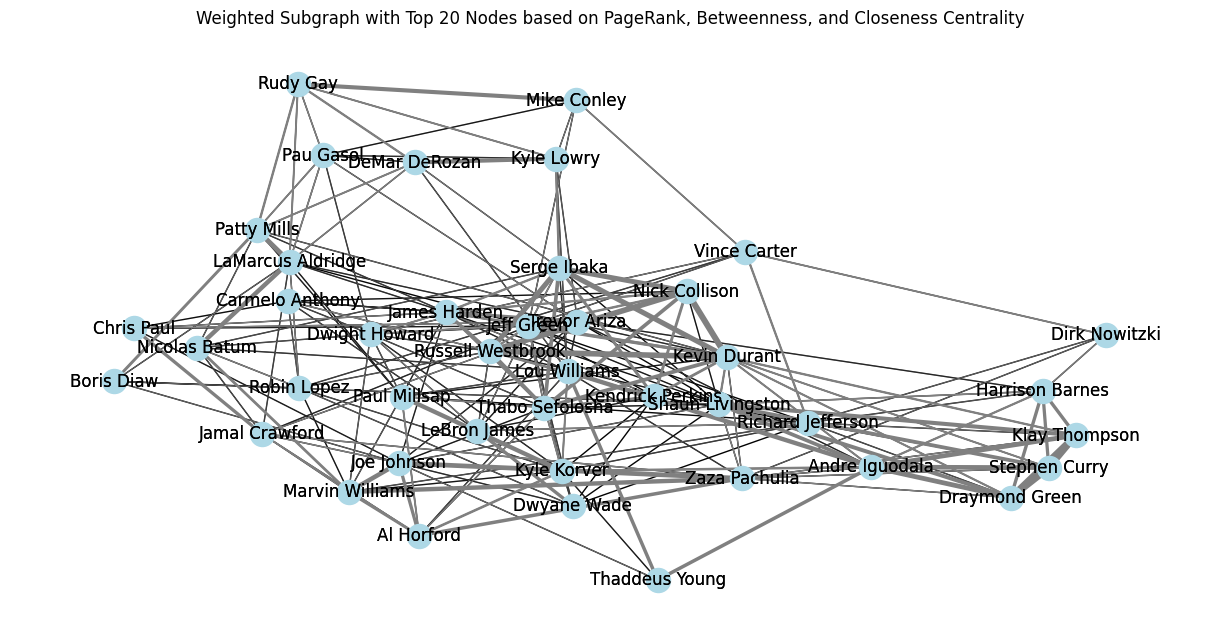

In [101]:
important_player_weight = set()
for node, value in top_20_pageranks_weight:
  important_player_weight.add(node)
for node, value in top20_close_central_weight:
  important_player_weight.add(node)
for node, value in top20_between_central_weight:
  important_player_weight.add(node)
subgraph = G_weighted.subgraph(important_player_weight)
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue')
weights = [subgraph[u][v]['count'] for u, v in subgraph.edges()]
max_weight = max(weights)
scaled_weights = [w * 5 / max_weight for w in weights]
nx.draw_networkx_edges(subgraph, pos, width=scaled_weights, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos)
plt.title("Weighted Subgraph with Top 20 Nodes based on PageRank, Betweenness, and Closeness Centrality")
plt.show()

## Analysis on Unweighted Graph

In [102]:
avg_short_dist_unweighted = nx.average_shortest_path_length(G_unweighted)

print("The average shortest distance between the nodes is ", avg_short_dist_unweighted)

The average shortest distance between the nodes is  2.422635051894152


In [103]:
transitivity_unweighted = nx.transitivity(G_unweighted)
avg_cluster_unweighted = nx.average_clustering(G_unweighted)
density_unweighted = nx.density(G_unweighted)
degree_assortativity_unweighted = nx.degree_assortativity_coefficient(G_unweighted)
print("The transitivity of network graph is ", transitivity_unweighted)
print("The average clustering coefficient is ", avg_cluster_unweighted)
print("The density of network graph is ", density_unweighted)
print("The degree assortativity of network graph is ", degree_assortativity_unweighted)

The transitivity of network graph is  0.21734196642623915
The average clustering coefficient is  0.5128515070340455
The density of network graph is  0.02551236153131191
The degree assortativity of network graph is  0.03806862541010994


In [104]:
pageranks_unweighted = nx.pagerank(G_unweighted, alpha=0.5)
pageranks_unweighted = sorted(pageranks_unweighted.items(), key=lambda t: t[1], reverse=True)
top_20_pageranks_unweighted = pageranks_unweighted[:20]
count = 1
for node, score in top_20_pageranks_unweighted:
    print(f"{count}: node {node} with PageRank score of {score}")
    count += 1

1: node Trevor Ariza with PageRank score of 0.0010379550552285857
2: node Jeff Green with PageRank score of 0.0009836818798173556
3: node Ish Smith with PageRank score of 0.0009805323668484122
4: node Vince Carter with PageRank score of 0.0009753334440156095
5: node Rajon Rondo with PageRank score of 0.0009600629276688194
6: node Anthony Tolliver with PageRank score of 0.0009479278871348365
7: node Garrett Temple with PageRank score of 0.0009331539198699945
8: node LeBron James with PageRank score of 0.0009303107159277596
9: node Joe Johnson with PageRank score of 0.0009287483572819465
10: node Carmelo Anthony with PageRank score of 0.0009283341246651555
11: node D.J. Augustin with PageRank score of 0.0009082423703715496
12: node Justin Holiday with PageRank score of 0.0009040960937452902
13: node Richard Jefferson with PageRank score of 0.000900917218498356
14: node George Hill with PageRank score of 0.000895994890777501
15: node Robin Lopez with PageRank score of 0.000894578899548487

In [105]:
avg_neighbor_degree_unweighted = nx.average_neighbor_degree(G_unweighted)
top20_avg_neighbor_degree_unweighted = sorted(avg_neighbor_degree_unweighted.items(), key=lambda t: t[1], reverse=True)[:20]
count = 1
for node, score in top20_avg_neighbor_degree_unweighted:
    print(f"{count}: node {node} with average neighbor degree of {score}")
    count += 1
print("These nodes have neighbors which are highly connected.")

1: node Michael Holyfield with average neighbor degree of 174.375
2: node Jeff Foote with average neighbor degree of 168.66666666666666
3: node Stanley Robinson with average neighbor degree of 168.66666666666666
4: node Rob Gray with average neighbor degree of 168.53846153846155
5: node David Lighty with average neighbor degree of 168.0909090909091
6: node Aaron Jackson with average neighbor degree of 167.4
7: node Willie Warren with average neighbor degree of 165.5
8: node Jordan Bachynski with average neighbor degree of 162.69230769230768
9: node Coleman Collins with average neighbor degree of 162.5
10: node Zoran Dragic with average neighbor degree of 162.06896551724137
11: node Casey Prather with average neighbor degree of 161.93333333333334
12: node Joe Jackson with average neighbor degree of 161.93333333333334
13: node Sim Bhullar with average neighbor degree of 161.64285714285714
14: node Angel Rodriguez with average neighbor degree of 159.5
15: node Josh Akognon with average ne

In [106]:
close_central_unweighted = nx.closeness_centrality(G_unweighted)
top20_close_central_unweighted = sorted(close_central_unweighted.items(), key=lambda t: t[1], reverse=True)[:20]
count = 1
for node, score in top20_close_central_unweighted:
    print(f"{count}: node {node} with closeness centrality of {score}")
    count += 1

1: node Anthony Tolliver with closeness centrality of 0.5205728116175877
2: node Jeff Green with closeness centrality of 0.5186897106109325
3: node Trevor Ariza with closeness centrality of 0.5185854932690376
4: node Garrett Temple with closeness centrality of 0.5168201842210652
5: node Rajon Rondo with closeness centrality of 0.5152725094829307
6: node Ish Smith with closeness centrality of 0.5142458657103008
7: node D.J. Augustin with closeness centrality of 0.5138363527772247
8: node LeBron James with closeness centrality of 0.5121031746031746
9: node JaVale McGee with closeness centrality of 0.512001586986709
10: node Carmelo Anthony with closeness centrality of 0.5117985326194725
11: node Gerald Green with closeness centrality of 0.5110891089108911
12: node Dwight Howard with closeness centrality of 0.5101798774461356
13: node Corey Brewer with closeness centrality of 0.5100790513833993
14: node DeAndre Jordan with closeness centrality of 0.5100790513833993
15: node Ersan Ilyasova

In [107]:
between_central_unweighted = nx.betweenness_centrality(G_unweighted)
top20_between_central_unweighted = sorted(between_central_unweighted.items(), key=lambda t: t[1], reverse=True)[:20]
count = 1
for node, score in top20_between_central_unweighted:
    print(f"{count}: node {node} with betweenness centrality of {score}")
    count += 1


1: node Trevor Ariza with betweenness centrality of 0.00878601875883008
2: node Vince Carter with betweenness centrality of 0.008182048726801469
3: node Garrett Temple with betweenness centrality of 0.007956223775676546
4: node Ish Smith with betweenness centrality of 0.007779265353155346
5: node Rajon Rondo with betweenness centrality of 0.007373729407230543
6: node Anthony Tolliver with betweenness centrality of 0.007313551007630948
7: node Jeff Green with betweenness centrality of 0.00717717796444618
8: node LeBron James with betweenness centrality of 0.007019972073472195
9: node Robin Lopez with betweenness centrality of 0.006870617333054298
10: node Carmelo Anthony with betweenness centrality of 0.006656279454419566
11: node Joe Johnson with betweenness centrality of 0.006649482001080681
12: node Richard Jefferson with betweenness centrality of 0.006525377306445222
13: node Chris Paul with betweenness centrality of 0.006258837571511117
14: node Justin Holiday with betweenness cent

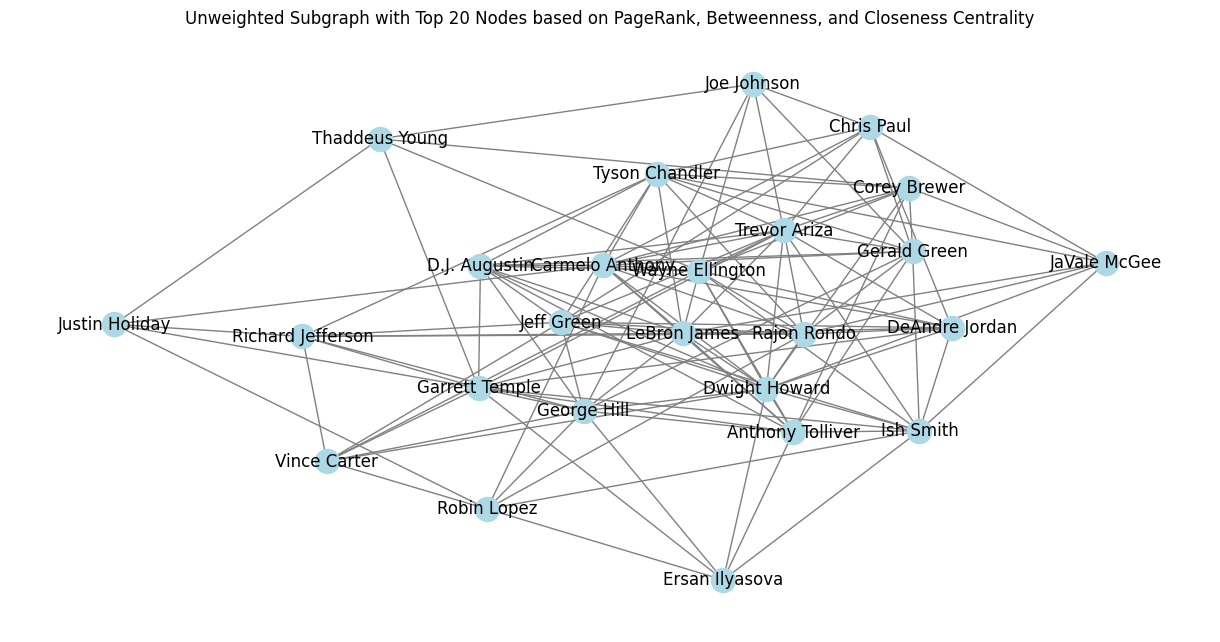

In [108]:
important_player_unweight = set()
for node, value in top_20_pageranks_unweighted:
  important_player_unweight.add(node)
for node, value in top20_close_central_unweighted:
  important_player_unweight.add(node)
for node, value in top20_between_central_unweighted:
  important_player_unweight.add(node)
subgraph = G_unweighted.subgraph(important_player_unweight)
plt.figure(figsize=(12, 6))
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Unweighted Subgraph with Top 20 Nodes based on PageRank, Betweenness, and Closeness Centrality")
plt.show()

In [109]:
important_player_unweight.intersection(important_player_weight)

{'Carmelo Anthony',
 'Chris Paul',
 'Dwight Howard',
 'Jeff Green',
 'Joe Johnson',
 'LeBron James',
 'Richard Jefferson',
 'Robin Lopez',
 'Thaddeus Young',
 'Trevor Ariza',
 'Vince Carter'}

# Cluserting Part

In [110]:
from bs4 import BeautifulSoup
import requests

In [111]:
response = requests.get("https://hoopshype.com/salaries/players/2018-2019/")
content = response.content

In [112]:
soup = BeautifulSoup(content, 'html.parser')


In [113]:
wrapper = soup.find('div', id='wrapper')
wrapper_holder = wrapper.find('div', class_='wrapper-holder')
main = wrapper_holder.find('div', id='main')
primary = main.find('div', id='primary')
table_content = primary.find('div', id='content')
content_container = table_content.find('div', id='content-container')
entry_content = content_container.find('div', class_='entry-content')
players_salary = entry_content.find('div', class_='hoopshype-salaries-wrap tabs tabs-noinit hoopshype-salaries-players')
salary_ranking = players_salary.find('div', class_='hh-salaries-ranking')
table = salary_ranking.find('table', class_='hh-salaries-ranking-table hh-salaries-table-sortable responsive')

In [114]:
salary_1819 = []
rows = table.find_all('tr')

for row in rows:
    # Extracting cells from the row
    cells = row.find_all('td')
    row_data = [cell.get_text().strip() for cell in cells]
    if row_data[0] != '':
      salary_1819.append([row_data[1], int(row_data[2][1:].replace(',',''))])

salary_1819_df = pd.DataFrame(salary_1819, columns = ['Name', 'Salary'])

In [146]:
salary = pd.read_csv(GOOGLE_PATH+'datasets/datadavis-nba-salaries/salaries_1985to2018.csv')
salary_player = pd.read_csv(GOOGLE_PATH+'datasets/datadavis-nba-salaries/players.csv')
salary_player = salary_player[['_id', 'name']]
salary = salary[['player_id', 'salary']].groupby('player_id').sum().reset_index()
salary = salary.merge(salary_player, left_on='player_id', right_on='_id')[['name', 'salary']]
salary.columns = ['Name', 'salary']
salary = salary.merge(salary_1819_df, how='outer').fillna(0)
salary['Total Salary'] = salary['salary'] + salary['Salary']
salary = salary[['Name', 'Total Salary']]
salary.columns = ['PLAYER_NAME', 'Total Salary']

In [126]:
data_new[['minutes', 'seconds']] = data_new['MIN'].str.split(':', expand=True)
data_new['minutes'] = data_new['minutes'].astype(float)
data_new['seconds'].fillna(0, inplace=True)
data_new['seconds'] = data_new['seconds'].astype(float)
data_new['play_time'] = data_new['minutes']*60 + data_new['seconds']
time_df = data_new[['play_time', 'PLAYER_NAME']].groupby('PLAYER_NAME').sum().reset_index()
time_df.columns = ['PLAYER_NAME', 'TOTAL_TIME']

<ipython-input-126-86043b23b320>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new[['minutes', 'seconds']] = data_new['MIN'].str.split(':', expand=True)
<ipython-input-126-86043b23b320>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['minutes'] = data_new['minutes'].astype(float)
<ipython-input-126-86043b23b320>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [144]:
close_central_df = pd.DataFrame(list(close_central_weight.items()), columns=['PLAYER_NAME', 'close_central'])
pageranks_df = pd.DataFrame(pageranks_weight, columns=['PLAYER_NAME', 'pageranks'])
between_central_df = pd.DataFrame(list(between_central_weight.items()), columns=['PLAYER_NAME', 'between_central'])
year_df = players[['PLAYER_NAME', 'SEASON']].groupby('PLAYER_NAME').count().reset_index()
year_df.columns = ['PLAYER_NAME', 'TOTAL_SEASON']
game_df = data_new[['PLAYER_NAME', 'GAME_ID']].groupby('PLAYER_NAME').count().reset_index()
game_df.columns = ['PLAYER_NAME', 'GAME_PLAYED']

In [154]:
cluster_df = close_central_df.merge(pageranks_df, on='PLAYER_NAME', how='inner')
cluster_df = cluster_df.merge(between_central_df, on='PLAYER_NAME', how='inner')
cluster_df = cluster_df.merge(year_df, on='PLAYER_NAME', how='left').fillna(0)
cluster_df = cluster_df.merge(game_df, on='PLAYER_NAME', how='left').fillna(0)
cluster_df = cluster_df.merge(salary, on='PLAYER_NAME', how='left').fillna(0)

In [177]:
# clustering based on these three attributes
# based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

range_n_clusters = [3, 4, 5, 6, 8]
range_n_components = [2, 3, 4, 5, 6]

X = cluster_df.iloc[:, 1:]

for n_clusters in range_n_clusters:
    for n_components in range_n_components:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=n_components, random_state=671)),
        ])
        X_transformed = pipe.fit_transform(X)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 42 for reproducibility.
        # clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        # cluster_labels = clusterer.fit_predict(X)
        cluster = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
        cluster_labels = cluster.fit_predict(X_transformed)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_transformed, cluster_labels)
        print("For n_clusters =", n_clusters, " and n_components = ", n_components,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(
            X_transformed, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        scatter = ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                              c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters, "and n_components = %d" % n_components),
                     fontsize=14, fontweight='bold')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [223]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=4, random_state=671)),
])
X = cluster_df.iloc[:, 1:]
X_transformed = pipe.fit_transform(X)

cluster = KMeans(n_clusters=8, n_init="auto", random_state=42)
cluster_labels = cluster.fit_predict(X_transformed)
table = pd.concat([cluster_df, pd.DataFrame({"label": cluster_labels})], axis=1)

In [224]:
table[table['PLAYER_NAME']=='Trevor Ariza']

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
206,Trevor Ariza,6.239852,0.00124,0.011706,12.0,1304,91320530.0,4


In [179]:
table[table['PLAYER_NAME']=='LeBron James']

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
165,LeBron James,6.272367,0.001496,0.054995,11.0,1738,272674622.0,7


In [181]:
table[table['PLAYER_NAME']=='Kyle Korver']

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
668,Kyle Korver,6.286462,0.001253,0.029218,13.0,1458,76707455.0,7


In [183]:
table[table['PLAYER_NAME']=='Thabo Sefolosha']

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
535,Thabo Sefolosha,6.279916,0.000862,0.015269,11.0,1028,44725228.0,2


In [225]:
table[table['label']==7]

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
36,Lou Williams,6.267618,0.001187,0.016979,12.0,1294,58208319.0,7
64,Serge Ibaka,6.290046,0.001002,0.021203,12.0,1125,96794058.0,7
89,Dirk Nowitzki,6.256372,0.001201,0.026147,10.0,1330,255371801.0,7
92,Harrison Barnes,6.235265,0.001020,0.023934,9.0,891,81981290.0,7
132,David West,6.259426,0.001114,0.021753,9.0,1220,92190459.0,7
165,LeBron James,6.272367,0.001496,0.054995,11.0,1738,272674622.0,7
257,Dwight Howard,6.254643,0.001239,0.018283,11.0,1447,238022587.0,7
274,Jamal Crawford,6.248108,0.001204,0.020092,10.0,1310,123993384.0,7
276,James Harden,6.270309,0.001050,0.026383,12.0,1173,148379888.0,7
302,Kyle Lowry,6.258025,0.001145,0.026022,11.0,1239,126161621.0,7


In [253]:
top100_close_central_weight = sorted(close_central_unweighted.items(), key=lambda t: t[1], reverse=True)[:200]
top100_pageranks_weight = sorted(pageranks_weight, key=lambda t: t[1], reverse=True)[:200]
top100_between_central_weight = sorted(between_central_weight.items(), key=lambda t: t[1], reverse=True)[:200]
top_close_central_df = pd.DataFrame(top100_close_central_weight, columns=['PLAYER_NAME', 'close_central'])
top_pageranks_df = pd.DataFrame(top100_pageranks_weight, columns=['PLAYER_NAME', 'pageranks'])
top_between_central_df = pd.DataFrame(top100_between_central_weight, columns=['PLAYER_NAME', 'between_central'])

In [254]:
new_cluster_df = top_close_central_df.merge(top_pageranks_df, on='PLAYER_NAME', how='inner')
new_cluster_df = new_cluster_df.merge(top_between_central_df, on='PLAYER_NAME', how='inner')
new_cluster_df = new_cluster_df.merge(year_df, on='PLAYER_NAME', how='left').fillna(0)
new_cluster_df = new_cluster_df.merge(game_df, on='PLAYER_NAME', how='left').fillna(0)
new_cluster_df = new_cluster_df.merge(salary, on='PLAYER_NAME', how='left').fillna(0)

In [255]:
new_cluster_df[new_cluster_df['PLAYER_NAME'] == 'Thabo Sefolosha']

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary
63,Thabo Sefolosha,0.492369,0.000862,0.015269,11,1028,44725228.0


For n_clusters = 2  and n_components =  3 The average silhouette_score is : 0.37980876315418644
For n_clusters = 2  and n_components =  4 The average silhouette_score is : 0.34574071229791614
For n_clusters = 2  and n_components =  5 The average silhouette_score is : 0.33246561461168583
For n_clusters = 2  and n_components =  6 The average silhouette_score is : 0.33155609291526145
For n_clusters = 3  and n_components =  3 The average silhouette_score is : 0.3461588015758717
For n_clusters = 3  and n_components =  4 The average silhouette_score is : 0.30365974138849594
For n_clusters = 3  and n_components =  5 The average silhouette_score is : 0.2851619735772572
For n_clusters = 3  and n_components =  6 The average silhouette_score is : 0.2763717911975917


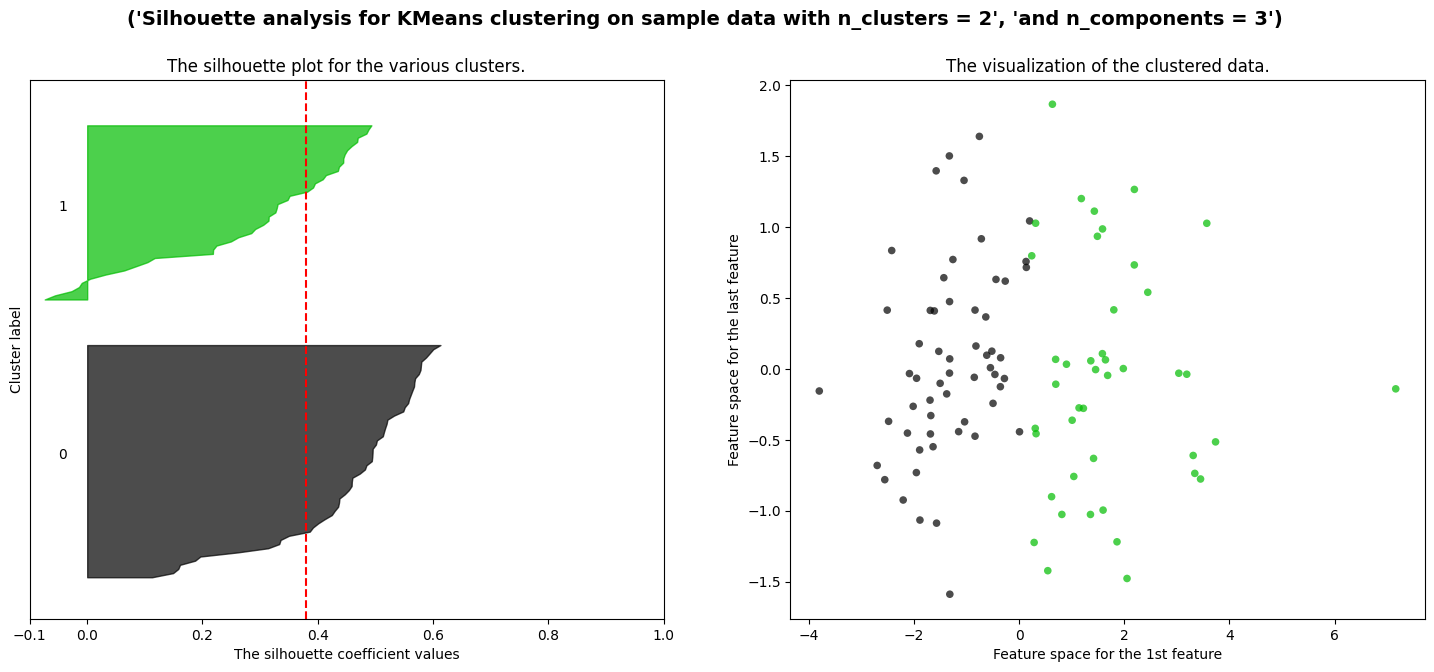

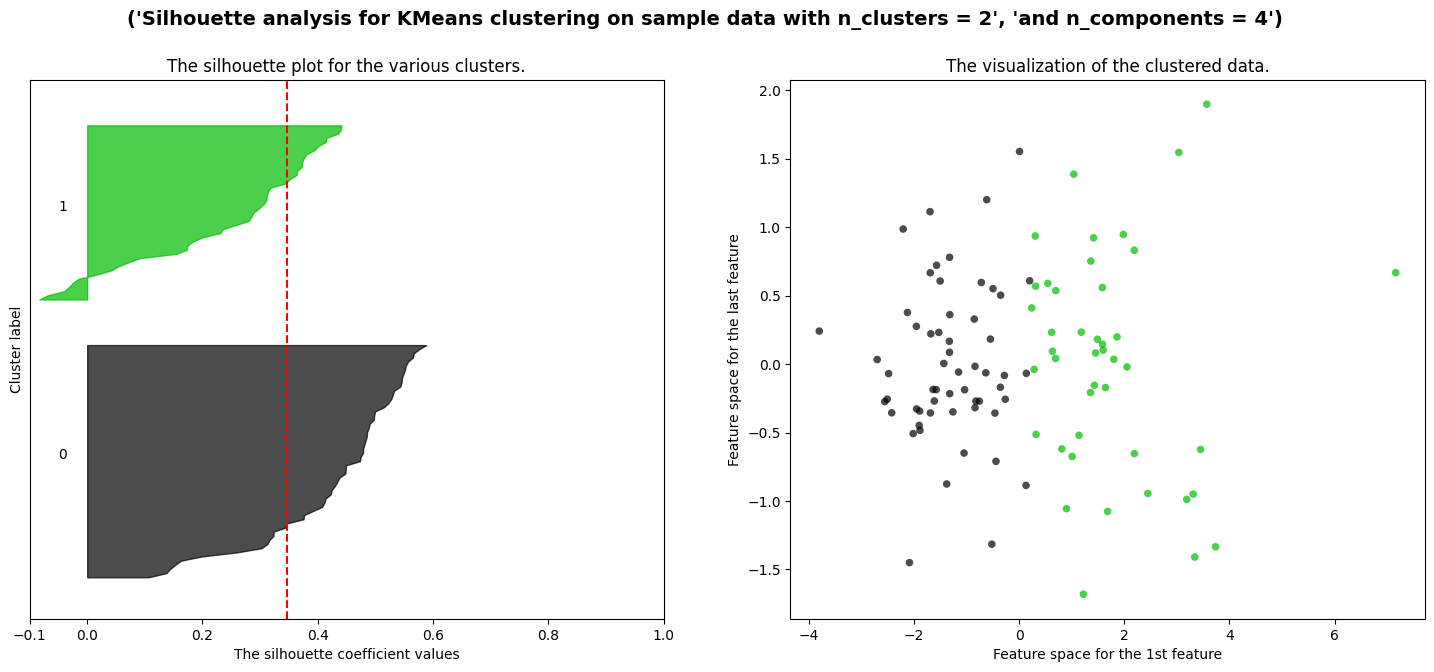

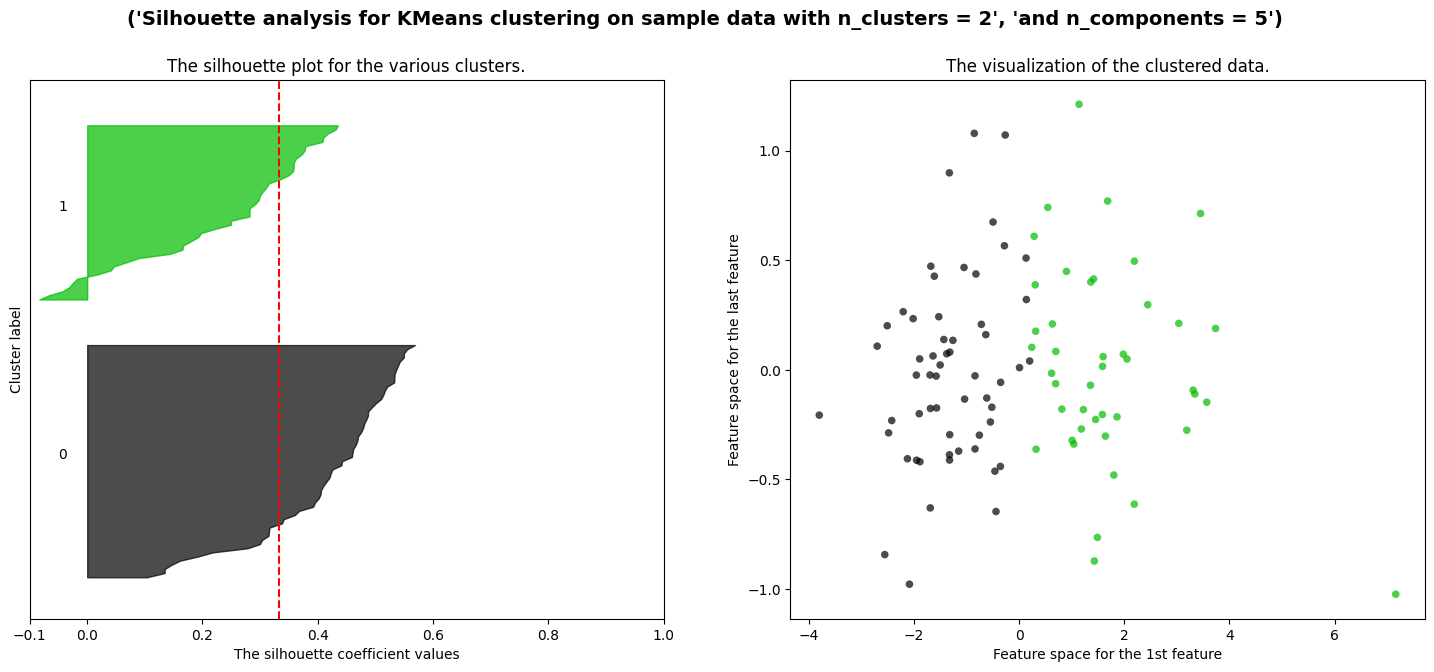

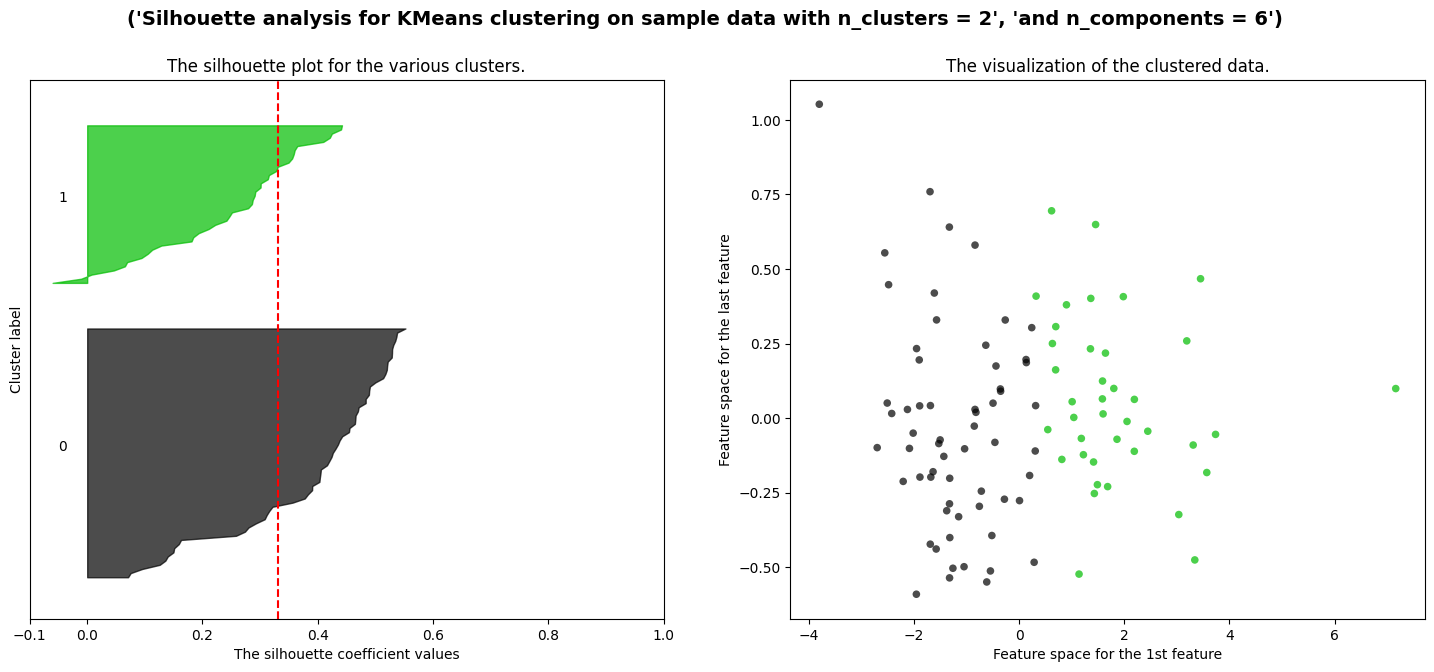

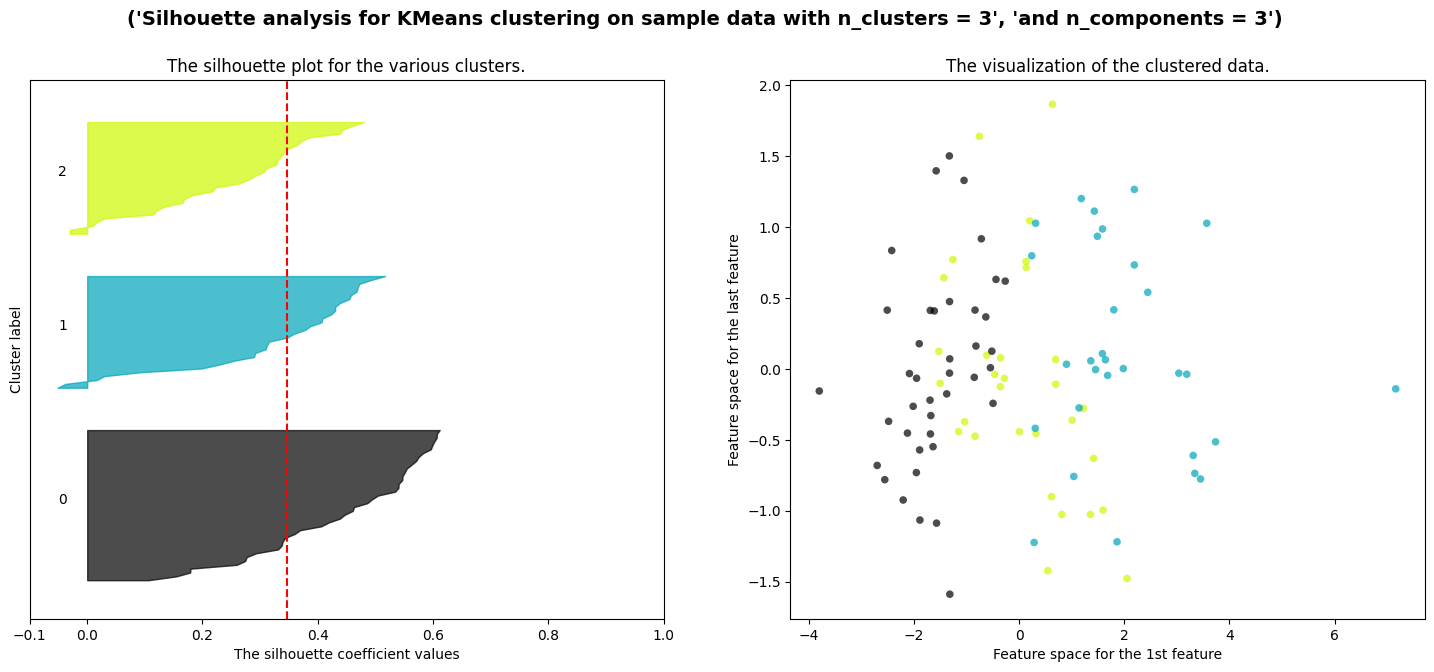

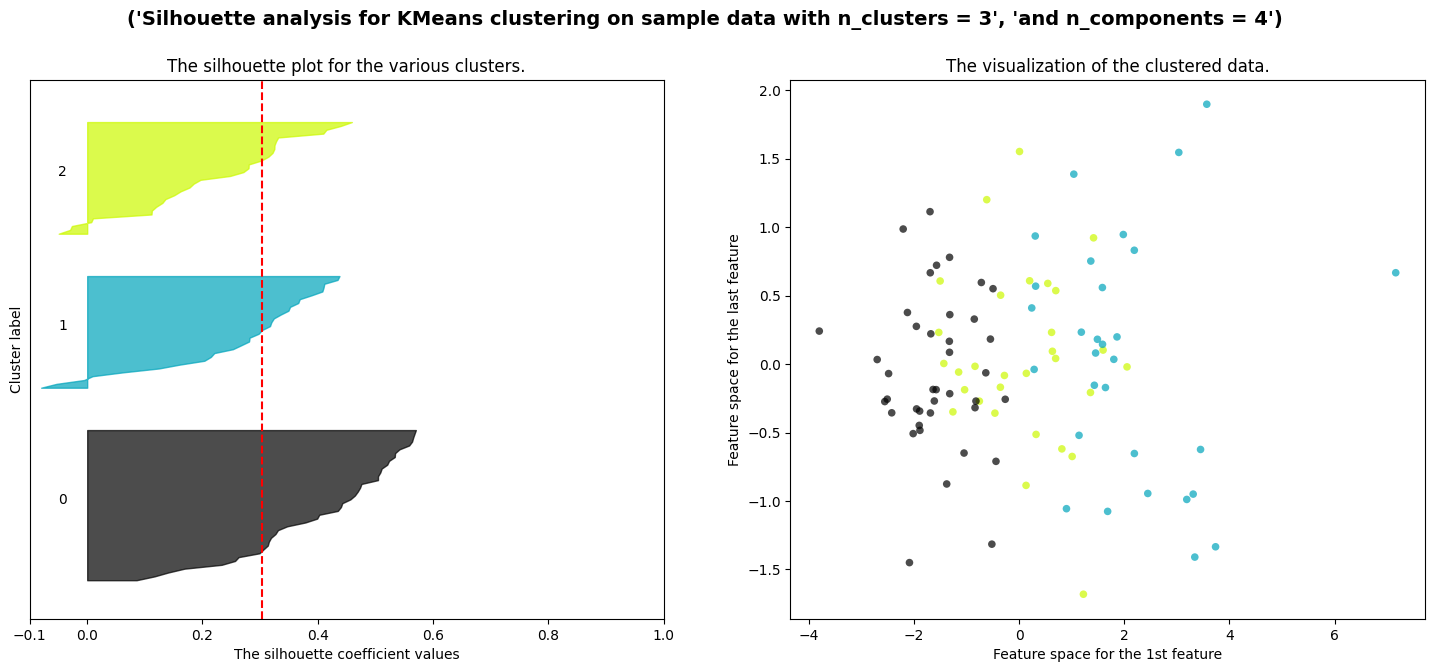

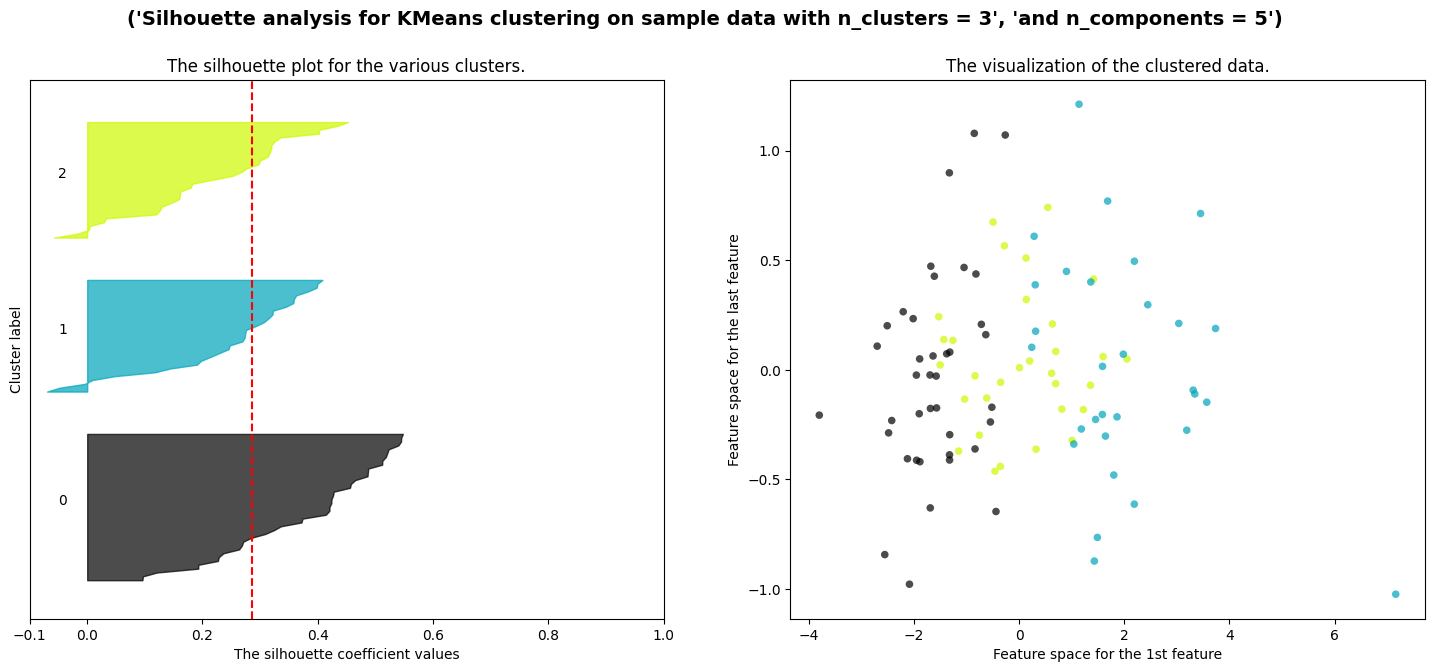

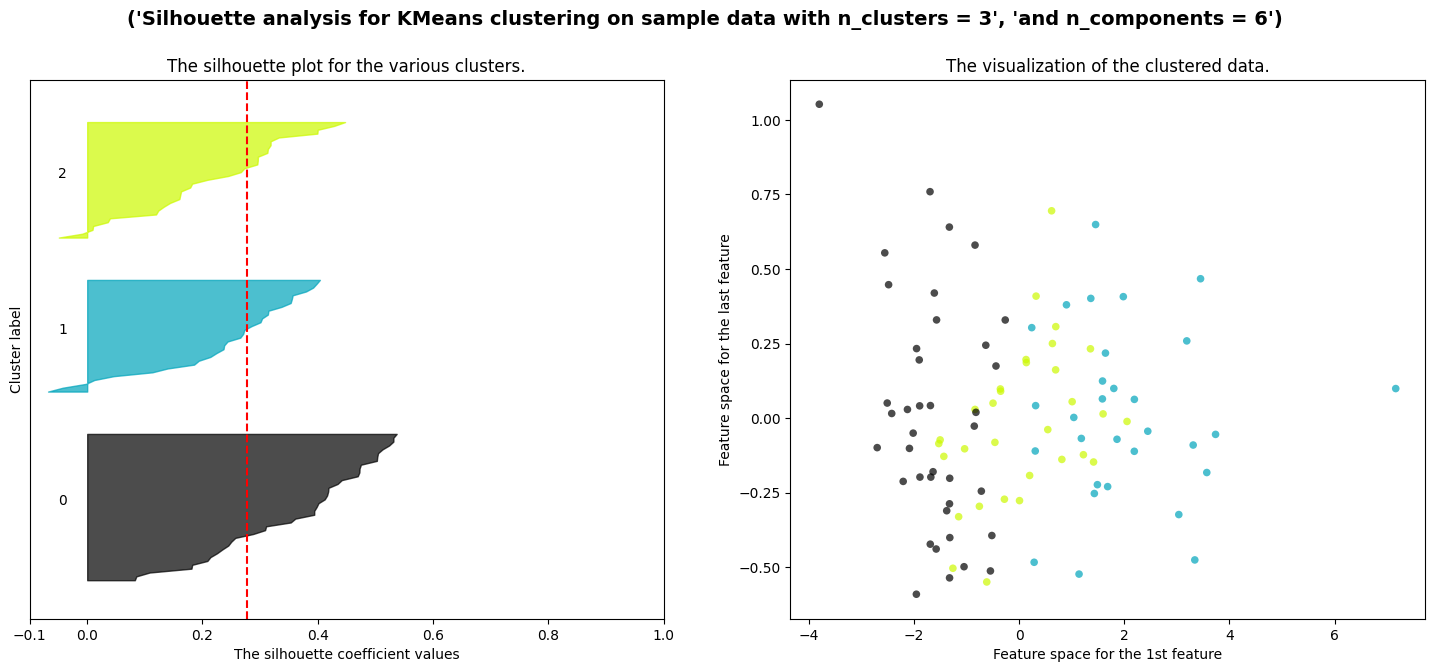

In [256]:
# clustering based on these three attributes
# based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


range_n_clusters = [2,3]
range_n_components = [3, 4, 5, 6]

X = new_cluster_df.iloc[:, 1:]

for n_clusters in range_n_clusters:
    for n_components in range_n_components:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components=n_components, random_state=671)),
        ])
        X_transformed = pipe.fit_transform(X)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 42 for reproducibility.
        # clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        # cluster_labels = clusterer.fit_predict(X)
        cluster = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
        cluster_labels = cluster.fit_predict(X_transformed)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_transformed, cluster_labels)
        print("For n_clusters =", n_clusters, " and n_components = ", n_components,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(
            X_transformed, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        scatter = ax2.scatter(X_transformed[:, 0], X_transformed[:, n_components-1], marker='o', s=30, lw=0, alpha=0.7,
                              c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the last feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters, "and n_components = %d" % n_components),
                     fontsize=14, fontweight='bold')

plt.show()


In [262]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=4, random_state=671)),
])
X = new_cluster_df.iloc[:, 1:]
X_transformed = pipe.fit_transform(X)

cluster = KMeans(n_clusters=3, n_init="auto", random_state=42)
cluster_labels = cluster.fit_predict(X_transformed)
new_table = pd.concat([new_cluster_df, pd.DataFrame({"label": cluster_labels})], axis=1)

In [263]:
pca = pipe.named_steps['pca']
pca.components_

array([[ 0.30470787,  0.50901392,  0.43080159,  0.2013355 ,  0.51841041,
         0.39138547],
       [ 0.60230242, -0.02965452, -0.30375052,  0.6554924 , -0.07868769,
        -0.32897719],
       [-0.46059346, -0.31617392,  0.35408094,  0.6821453 , -0.17353422,
         0.25899434],
       [-0.14929134,  0.08820794,  0.541364  ,  0.00589341,  0.15845531,
        -0.80728784]])

In [265]:
matrix = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(4)])

In [266]:
matrix

,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary
PC1,0.304708,0.509014,0.430802,0.201336,0.518410,0.391385
PC2,0.602302,-0.029655,-0.303751,0.655492,-0.078688,-0.328977
PC3,-0.460593,-0.316174,0.354081,0.682145,-0.173534,0.258994
PC4,-0.149291,0.088208,0.541364,0.005893,0.158455,-0.807288


In [267]:
new_table[new_table['label']==1]

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
4,LeBron James,0.512103,0.001496,0.054995,11,1738,272674622.0,1
6,Carmelo Anthony,0.511799,0.001312,0.018583,12,1428,234395302.0,1
7,Dwight Howard,0.510180,0.001239,0.018283,11,1447,238022587.0,1
11,Vince Carter,0.509374,0.001391,0.017973,12,1382,184321331.0,1
12,Joe Johnson,0.509374,0.001253,0.022828,12,1308,220040806.0,1
15,Chris Paul,0.508171,0.001272,0.021727,11,1403,220642627.0,1
16,Kyle Korver,0.507671,0.001253,0.029218,13,1458,76707455.0,1
17,Jamal Crawford,0.506277,0.001204,0.020092,10,1310,123993384.0,1
23,Thaddeus Young,0.502531,0.001226,0.025851,12,1244,96497787.0,1
28,Al Horford,0.500194,0.001148,0.022993,11,1198,160728232.0,1


In [268]:
new_table[new_table['label']==2]

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
0,Jeff Green,0.518690,0.001189,0.010232,13,1238,69824630.0,2
1,Trevor Ariza,0.518585,0.001240,0.011706,12,1304,91320530.0,2
2,Rajon Rondo,0.515273,0.001101,0.006198,12,1164,99582884.0,2
3,D.J. Augustin,0.513836,0.001118,0.011030,14,1095,35638310.0,2
5,JaVale McGee,0.512002,0.000985,0.006842,13,987,57492164.0,2
8,Corey Brewer,0.510079,0.000851,0.005558,16,935,52965852.0,2
9,DeAndre Jordan,0.510079,0.001094,0.011779,12,1136,131385089.0,2
10,Tyson Chandler,0.509878,0.001089,0.007506,12,1159,187081273.0,2
13,Richard Jefferson,0.508973,0.001187,0.013884,11,1198,116009560.0,2
14,George Hill,0.508271,0.001087,0.012813,13,1104,84331400.0,2


In [269]:
new_table[new_table['label']==0]

,PLAYER_NAME,close_central,pageranks,between_central,TOTAL_SEASON,GAME_PLAYED,Total Salary,label
38,Matt Barnes,0.498551,0.000992,0.004588,9,1088,31408015.0,0
41,Luol Deng,0.497878,0.000936,0.005844,11,1046,153461551.0,0
44,Jeff Teague,0.496920,0.000902,0.007904,11,967,77663717.0,0
45,Kent Bazemore,0.496824,0.000881,0.005358,9,754,55992815.0,0
46,Kevin Love,0.495584,0.000944,0.015003,11,958,146321469.0,0
47,Jae Crowder,0.495584,0.000889,0.007399,10,891,28692956.0,0
49,Eric Bledsoe,0.494919,0.000894,0.004861,11,853,76176423.0,0
51,P.J. Tucker,0.494729,0.001003,0.010325,9,951,26149241.0,0
52,Eric Gordon,0.494729,0.000983,0.013258,11,894,109485266.0,0
59,Tristan Thompson,0.493028,0.000894,0.007434,10,853,80393980.0,0
